<a href="https://colab.research.google.com/github/yangshuxuan/traceanalyze/blob/master/clean_glitch_of_a_trace.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 引言
本文档采用了三个方式试图清理掉轨迹的毛刺点。前两种方式是采用聚类，找到离群点并丢弃，分别是DBScan和Optics，注意KMeans等其他聚类方法一般来讲是不合适的，因为这些聚类一般针对球状聚簇比较有效，而轨迹显然不是球状的聚簇，这两种聚类简单有效，有很好的库支持，但是由于没有考虑到轨迹时间因素，有可能清理的时候激进导致合理的轨迹点被丢弃。

---
另外一种方式就是计算速度，这个考虑了时间，但是如果采样方式非常稀疏，有可能导致盘旋等情况下速度为0,这是一个值得注意的现象。


# 引入需要用到的库

Next, import the libraries that we will use.

In [149]:
import numpy as np
import pandas as pd
from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice

import matplotlib.pyplot as plt
import matplotlib.font_manager as fm



## 安装中文字体

In [150]:
!wget https://fonts.google.com/download?family=Noto%20Sans%20SC  -O Noto_Sans_SC.zip
!unzip -o Noto_Sans_SC.zip
!mv *.otf /usr/share/fonts/truetype/
path = '/usr/share/fonts/truetype/NotoSansSC-Light.otf'
fontprop = fm.FontProperties(fname=path, size= 10)

--2020-07-13 06:09:57--  https://fonts.google.com/download?family=Noto%20Sans%20SC
Resolving fonts.google.com (fonts.google.com)... 74.125.31.102, 74.125.31.138, 74.125.31.101, ...
Connecting to fonts.google.com (fonts.google.com)|74.125.31.102|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘Noto_Sans_SC.zip’

Noto_Sans_SC.zip        [    <=>             ]  41.03M  61.4MB/s    in 0.7s    

2020-07-13 06:10:04 (61.4 MB/s) - ‘Noto_Sans_SC.zip’ saved [43025060]

Archive:  Noto_Sans_SC.zip
  inflating: OFL.txt                 
  inflating: NotoSansSC-Thin.otf     
  inflating: NotoSansSC-Light.otf    
  inflating: NotoSansSC-Regular.otf  
  inflating: NotoSansSC-Medium.otf   
  inflating: NotoSansSC-Bold.otf     
  inflating: NotoSansSC-Black.otf    


### 测试中文字体是否管用

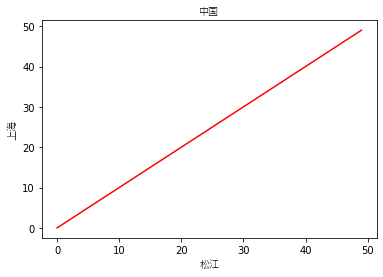

In [151]:
plt.plot(range(50), range(50), 'r')
plt.title('中国', fontproperties=fontprop)
plt.ylabel('上海', fontproperties=fontprop)
plt.xlabel('松江', fontproperties=fontprop)
plt.show()

# 设置随机种子
结果可重现

In [152]:
np.random.seed(0)

# 生成正常的轨迹点间隔值
这里假设飞机以800Km/h的速度巡航，每分钟定位一次，因此每分钟的纬度和经度的各自增加大概为0.1。

In [153]:
normalMu, normalSigma = 0.1, 0.1 # 经纬度增量平均值和标准方差
normalSampleNum = 500 #样本数
normalIntervalSample = np.random.normal(normalMu, normalSigma, (normalSampleNum,2)) #同时生成经度和纬度的增量，因此是2

# 设置轨迹起点
纬度在前，经度在后

In [154]:
startPoint=[31.23, 121.47] #此处是China ShangHai

# 生成正常轨迹
此处沿axix=0累加，然后都加上起点的经纬度

In [155]:
normalSample = normalIntervalSample.cumsum(0) + np.array(startPoint).reshape((1,2))

# 生成异常轨迹点间隔值
类似于正常轨迹点间隔值的生成，但是方差较大，并且需要指定毛刺点的占比。

In [156]:
abnormalMu, abnormalSigma = 0.1, 10.0 # mean and standard deviation
abnormalSamplePercent = 0.01 #毛刺点在总体的占比
abnormalSampleNum = int(normalSampleNum *  abnormalSamplePercent)
abnormalIntervalSample = np.random.normal(abnormalMu, abnormalSigma, (abnormalSampleNum,2))

# 选择需要替换为毛刺点的正常轨迹的索引

In [157]:
normalSampleIndexArr = np.arange(1,normalSampleNum) #默认起点不是毛刺点，因此从1开始采样
np.random.shuffle(normalSampleIndexArr) #随机打乱


# 将部分正常点替换为毛刺点

In [158]:
normalSample[normalSampleIndexArr[0:abnormalSampleNum]] = normalSample[normalSampleIndexArr[0:abnormalSampleNum]-1]+abnormalIntervalSample

# 转成DataFrame并画图展示

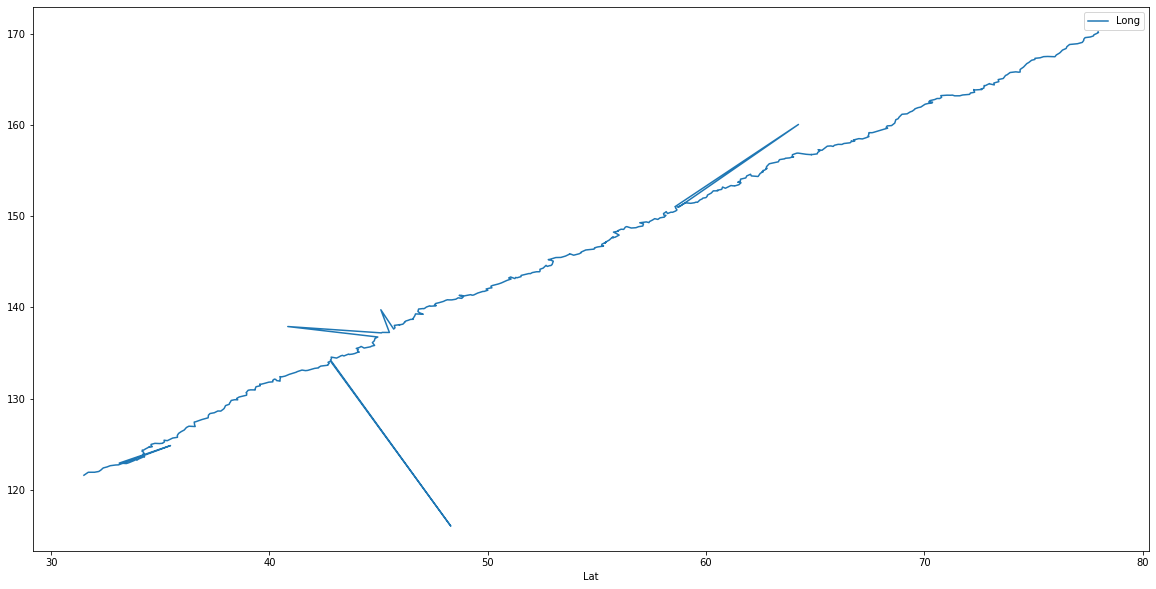

In [159]:
df = pd.DataFrame(normalSample,columns=['Lat', 'Long'])
df.plot.line(x = 'Lat', y = 'Long',figsize=(20,10))

# DBScan清理毛刺
DBScan可以对任意形状进行聚类，因此可以尝试用来清理毛刺，因为毛刺可以认为是离群点，因此这个问题就变成清理离群点。

## 地球半径以千米为单位

In [160]:
kms_per_rad = 6371.0088

## 设置样本数
假设飞机以800公里/小时飞行，每分钟定位一次，那么差不多每分钟飞行14公里，那么每个点前后30公里范围内大概有5个点（包括自身），那么可以认为有3个点可以证明这不是离群点。

In [161]:
eps = 40 
epsilon = eps/kms_per_rad #变成弧度，因为后面DBScan算法将会使用弧度来cluster
min_sample=3

## 使用DBSCan算法聚类
metric使用haversine，可以参考[scikit](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.haversine_distances.html?highlight=haversine#sklearn.metrics.pairwise.haversine_distances)
计算之前也需要将角度变成弧度，同时纬度在前，经度在后。

In [162]:
fac_coords = normalSample
dbsc = cluster.DBSCAN(eps=epsilon, min_samples=min_sample, algorithm='ball_tree', metric='haversine').fit(np.radians(fac_coords))
y_pred = dbsc.labels_

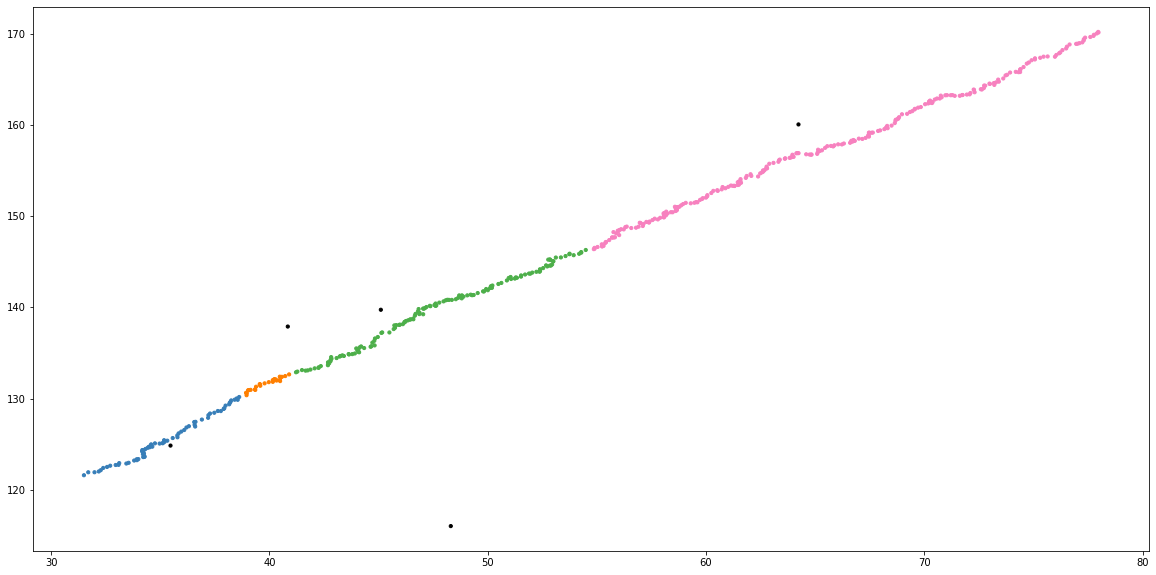

In [163]:
colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a','#f781bf', '#a65628', '#984ea3','#999999', '#e41a1c', '#dede00']),int(max(y_pred) + 1))))
# add black color for outliers (if any)
colors = np.append(colors, ["#000000"])
plt.figure(figsize=(20,10))
plt.scatter(fac_coords[:, 0],fac_coords[:, 1], s=10, color=colors[y_pred])

清理毛刺，离群点的label一般为-1

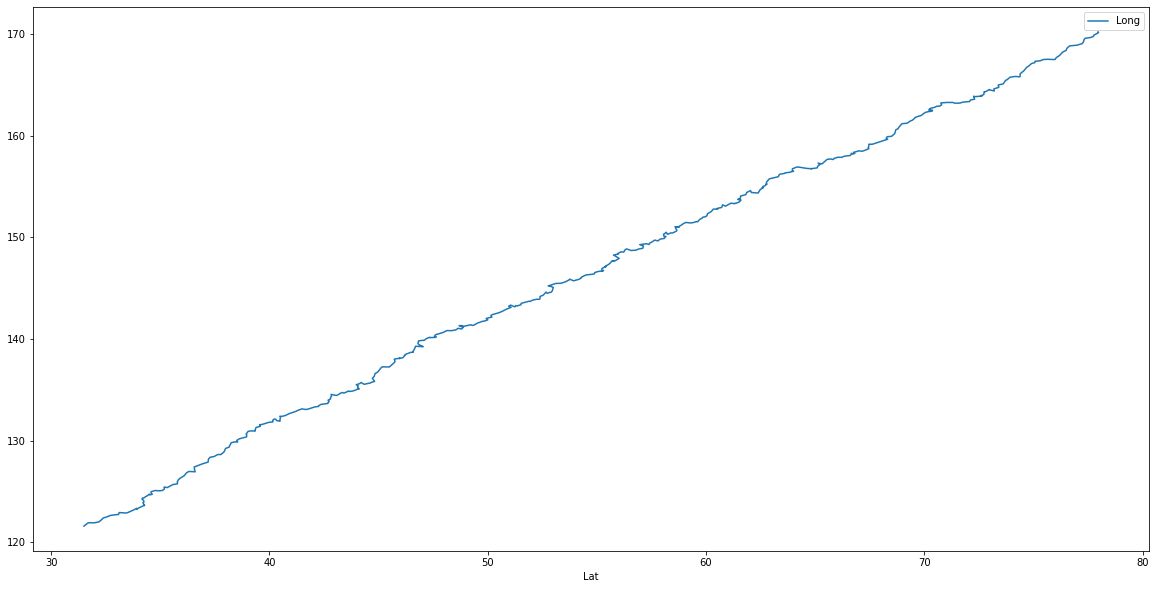

In [164]:
afterCleanGlitch = normalSample[y_pred != -1]
pd.DataFrame(afterCleanGlitch,columns=['Lat', 'Long']).plot.line(x = 'Lat', y = 'Long',figsize=(20,10))

### 分析
如上面两个图所示，尽管有多个cluster，但还是把离群点即毛刺清理掉了

### 结论
这个方法很容易使用，但是忽略了时间因素，如果毛刺点恰好混入到先前的轨迹点中，这个毛刺就不太容易清理了。

## 比较不同参数设置时的毛刺处理效果

### 设置参数列表

In [165]:
epses = np.arange(30,100,10)/kms_per_rad 

min_samples= np.arange(2,10,2)

numepses = len(epses)
nummin_samples = len(min_samples)

In [166]:
def drawEachPicture(epse,min_sample,fac_coords,indexi,indexj,axs):
  path = '/usr/share/fonts/truetype/NotoSansSC-Light.otf'
  fontprop = fm.FontProperties(fname=path, size= 15)
  dbsc = cluster.DBSCAN(eps=epse, min_samples=min_sample, algorithm='ball_tree', metric='haversine').fit(np.radians(fac_coords))
  y_pred = dbsc.labels_
  colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a','#f781bf', '#a65628', '#984ea3','#999999', '#e41a1c', '#dede00']),int(max(y_pred) + 1))))
  # add black color for outliers (if any)
  colors = np.append(colors, ["#000000"])

  curPlot = axs[indexi,indexj]
  if indexi == 0:
    curPlot.set_title("最少样本数%d"%(min_sample,),fontproperties=fontprop)
  curPlot.text(.99, .01, ('半径%.0f千米 离群点 %d' % (epse * kms_per_rad,(y_pred == -1).sum())).lstrip('0'), size=10,horizontalalignment='right',transform=curPlot.transAxes,fontproperties=fontprop)
  curPlot.set_ylabel('经度', fontproperties=fontprop)
  curPlot.set_xlabel('纬度', fontproperties=fontprop)
  curPlot.scatter(fac_coords[:, 0],fac_coords[:, 1], s=10, color=colors[y_pred])
  

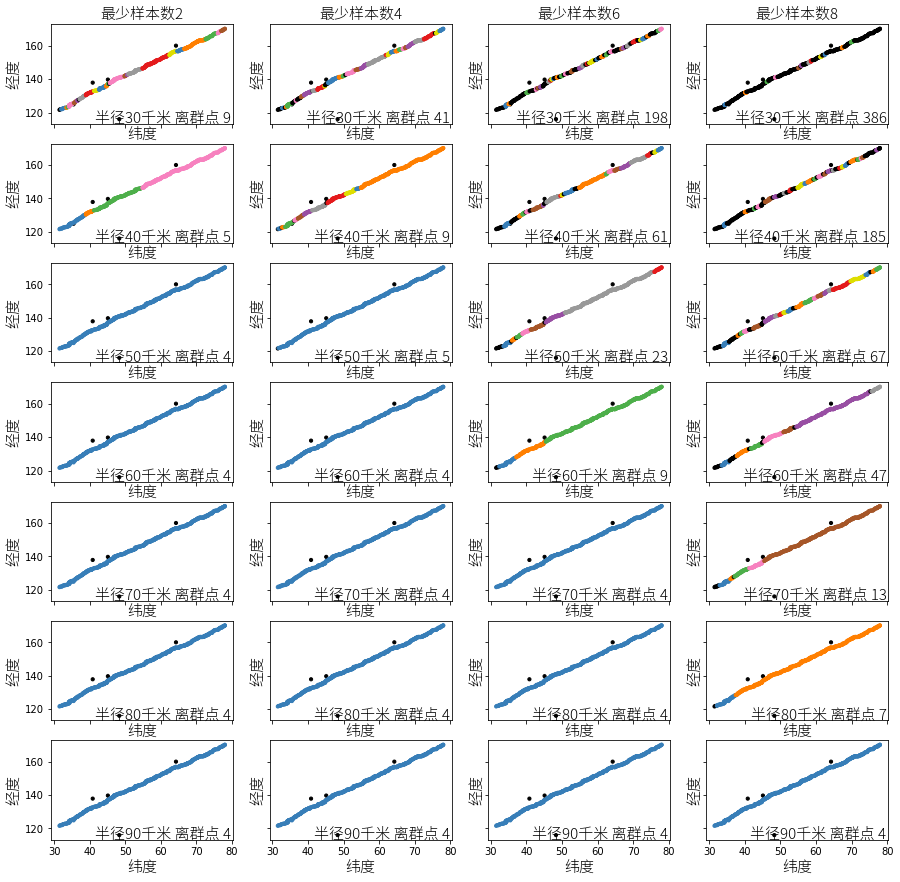

In [167]:
f, axs = plt.subplots(numepses,nummin_samples,figsize=(15,15), sharex=True, sharey=True)
for indexi,i in  enumerate(epses):
  for indexj,j in enumerate(min_samples):
    drawEachPicture(i,j,normalSample,indexi,indexj,axs)

  

### 结论
如果半径小而且样本数要求多的情况下，基本无法识别真正的离群点。

# Optics清理毛刺

## 用XI方法聚类

In [168]:
def drawEachPictureOptics(xi,min_sample,fac_coords,indexi,indexj,axs):
  path = '/usr/share/fonts/truetype/NotoSansSC-Light.otf'
  fontprop = fm.FontProperties(fname=path, size= 15)
 
  #dbsc = cluster.DBSCAN(eps=epse, min_samples=min_sample, algorithm='ball_tree', metric='haversine').fit(np.radians(fac_coords))
  optics = cluster.OPTICS(min_samples=min_sample,xi=xi,algorithm='ball_tree',metric='haversine').fit(np.radians(fac_coords))
  y_pred = optics.labels_
  colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a','#f781bf', '#a65628', '#984ea3','#999999', '#e41a1c', '#dede00']),int(max(y_pred) + 1))))
  # add black color for outliers (if any)
  colors = np.append(colors, ["#000000"])

  curPlot = axs[indexi,indexj]
  if indexi == 0:
    curPlot.set_title("最少样本数%d"%(min_sample,),fontproperties=fontprop)
  curPlot.text(.99, .01, ('xi is %.3f 离群点 %d ' % (xi,(y_pred == -1).sum())).lstrip('0'), size=10,horizontalalignment='right',transform=curPlot.transAxes,fontproperties=fontprop)
  curPlot.set_ylabel('经度', fontproperties=fontprop)
  curPlot.set_xlabel('纬度', fontproperties=fontprop)
  curPlot.scatter(fac_coords[:, 0],fac_coords[:, 1], s=10, color=colors[y_pred])

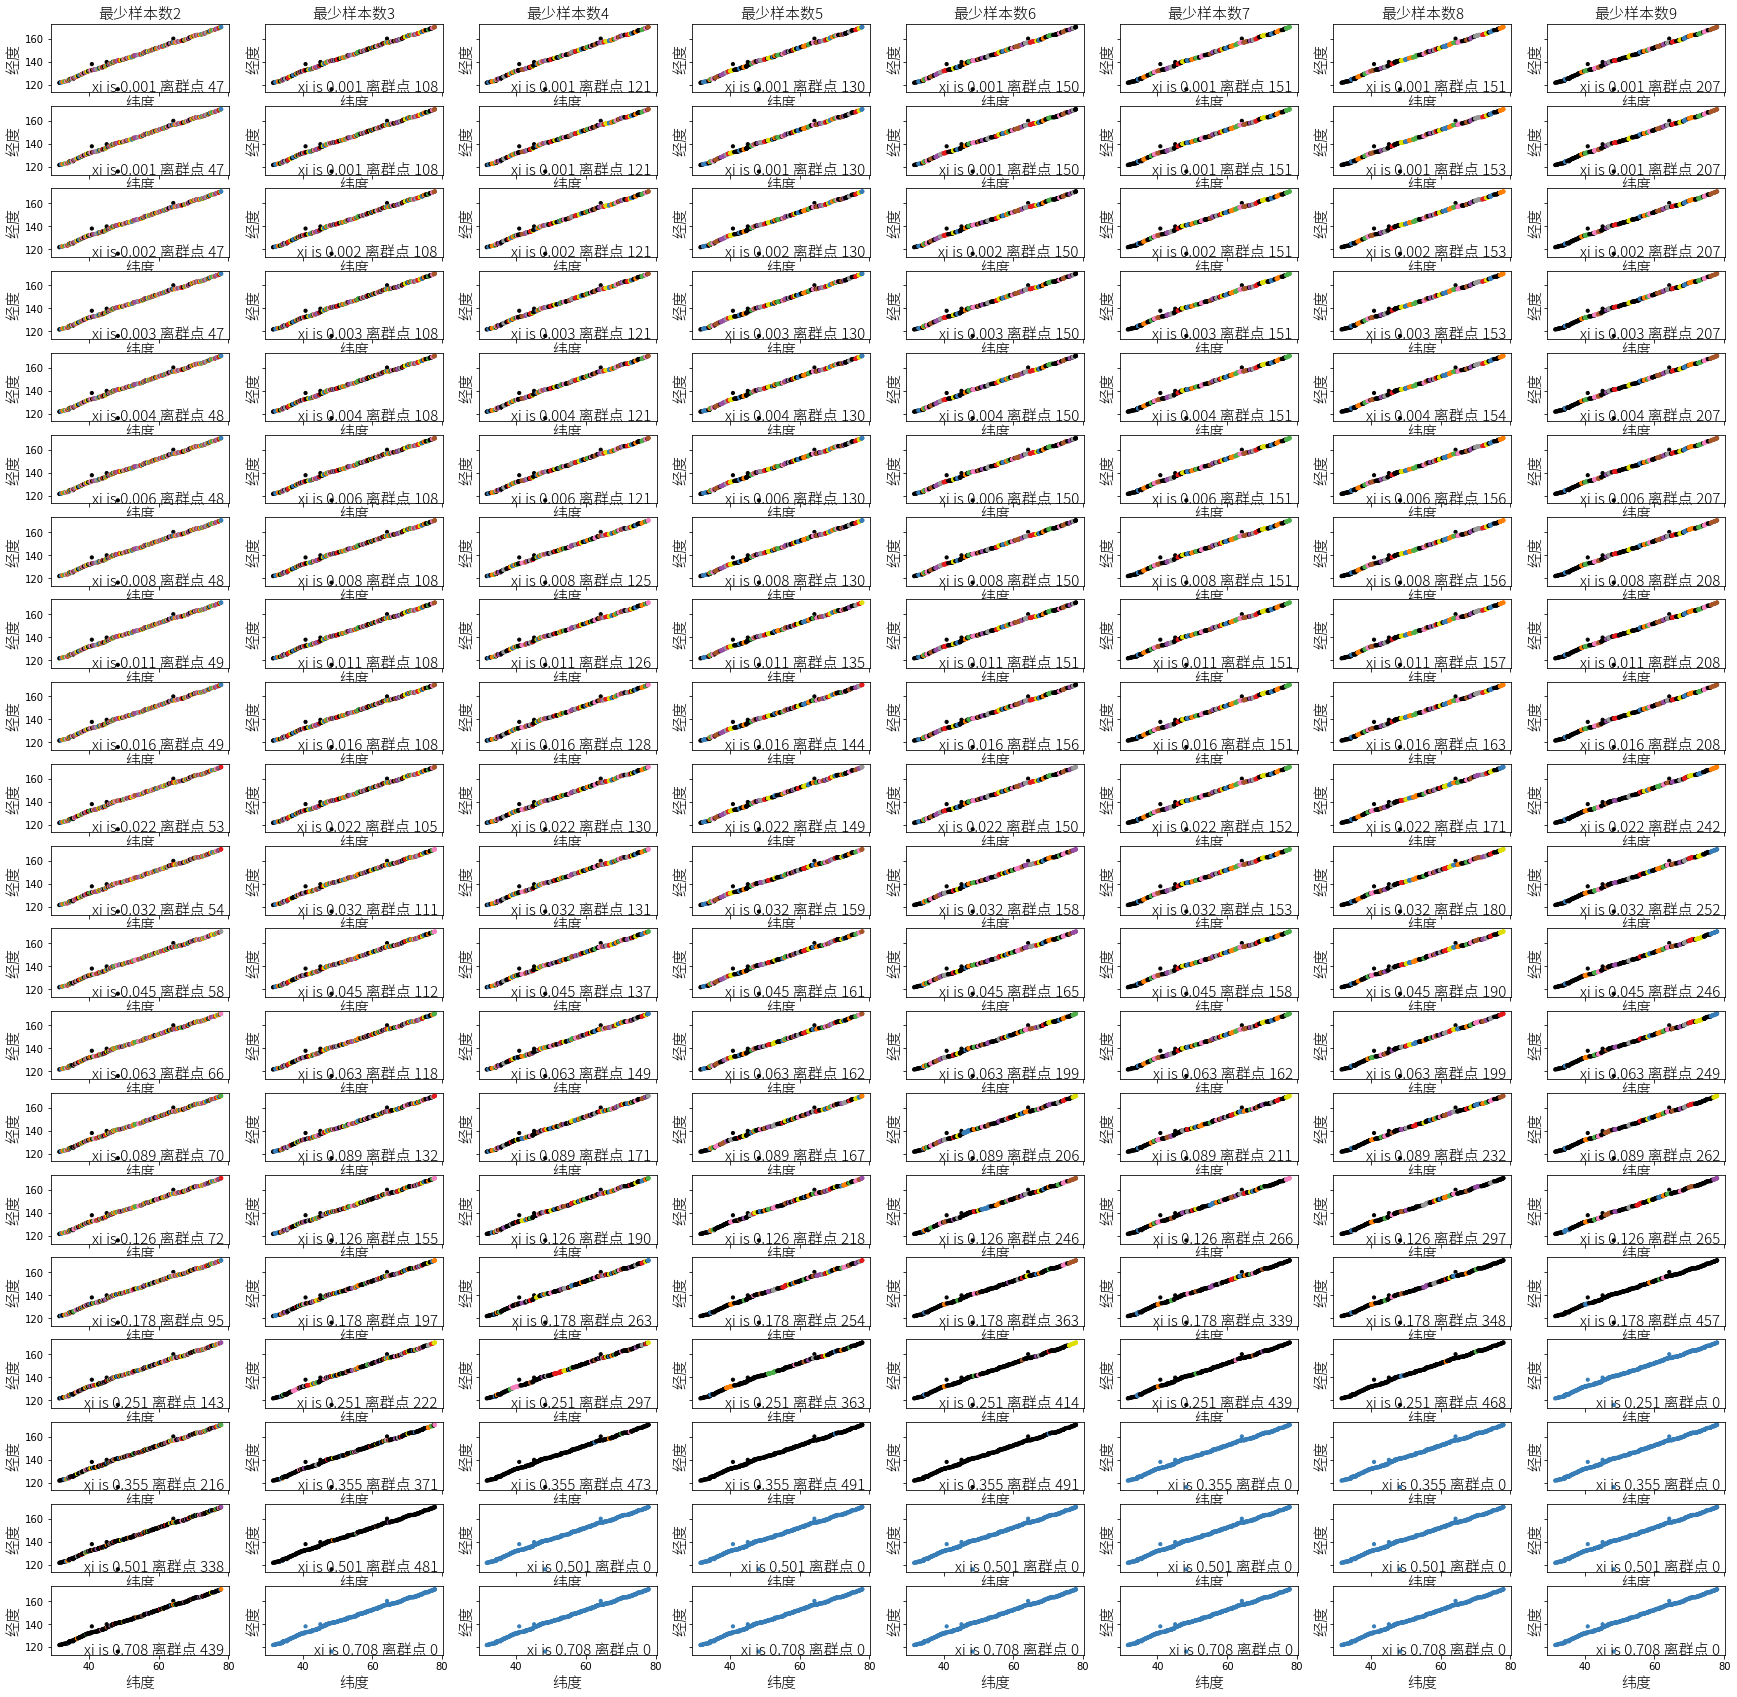

In [169]:
xis2 = np.geomspace(0.001, 1.0, num=20,endpoint=False)
samples2 = np.arange(2,10,1)
f2, axs2 = plt.subplots(len(xis2),len(samples2),figsize=(30,30), sharex=True, sharey=True)
for indexi,i in  enumerate(xis2):
  for indexj,j in enumerate(samples2):
    drawEachPictureOptics(i,j,normalSample,indexi,indexj,axs2)

### 结论
从上面的结果看，效果相当不好，无法区分离群点

## 用DBScan方法聚类

In [170]:
def drawEachPictureOpticsDBScan(epse,min_sample,fac_coords,indexi,indexj,axs):
  path = '/usr/share/fonts/truetype/NotoSansSC-Light.otf'
  fontprop = fm.FontProperties(fname=path, size= 15)
 
  #dbsc = cluster.DBSCAN(eps=epse, min_samples=min_sample, algorithm='ball_tree', metric='haversine').fit(np.radians(fac_coords))
  optics = cluster.OPTICS(eps=epse,min_samples=min_sample,cluster_method='dbscan',algorithm='ball_tree',metric='haversine').fit(np.radians(fac_coords))
  y_pred = optics.labels_
  colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a','#f781bf', '#a65628', '#984ea3','#999999', '#e41a1c', '#dede00']),int(max(y_pred) + 1))))
  # add black color for outliers (if any)
  colors = np.append(colors, ["#000000"])

  curPlot = axs[indexi,indexj]
  if indexi == 0:
    curPlot.set_title("最少样本数%d"%(min_sample,),fontproperties=fontprop)
  curPlot.text(.99, .01, ('半径%.0f千米 离群点 %d' % (epse * kms_per_rad,(y_pred == -1).sum())).lstrip('0'), size=10,horizontalalignment='right',transform=curPlot.transAxes,fontproperties=fontprop)
  curPlot.set_ylabel('经度', fontproperties=fontprop)
  curPlot.set_xlabel('纬度', fontproperties=fontprop)
  curPlot.scatter(fac_coords[:, 0],fac_coords[:, 1], s=10, color=colors[y_pred])

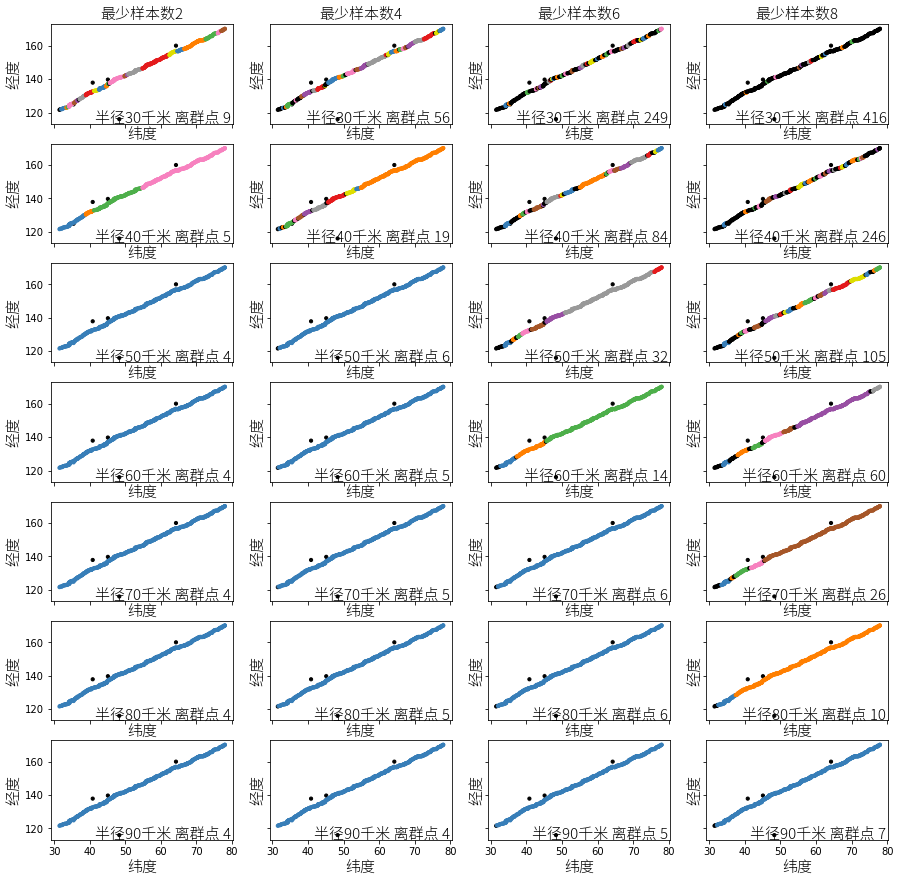

In [171]:
f3, axs3 = plt.subplots(numepses,nummin_samples,figsize=(15,15), sharex=True, sharey=True)
for indexi,i in  enumerate(epses):
  for indexj,j in enumerate(min_samples):
    drawEachPictureOpticsDBScan(i,j,normalSample,indexi,indexj,axs3)

### 结论
离群点和半径必须相互配合，尽管这里没有直接试用时间，但是时间在这里面起了间接作用，因为时间或者速度，决定了在合理的半径范围内有多少个点才不会认为是离群点。

# 使用目标合理的移动速度去毛刺


1. 对于速度过低的点暂时认为合理的，因为目标在采样时间内有可能盘旋回来了，这时速度现有的方法计算的速度可能过低；
2. 对于速度过高的点，可以认为是潜在不合理的，现有的计算方式是最短路径的方式，因此获得的速度应该低于实际速度，如果该速度高于合理值，那么显然是离群点；
3. 假设离群点不太可能聚集在某处，因为离群点是随机噪音，不是bias，因此我们可以计算个点到各时间临近点的距离，然后除以间隔时间，获得速度；
4. 不能随机选择邻近点，因为有可能毛刺会混入到先前的轨迹中。

## 增加时间序列

In [172]:
start = np.datetime64('2005-02-25T03:30')
end = start + np.timedelta64(500,'m')
timeColumn = np.arange(start, end, dtype='datetime64[m]').reshape((500,1)) #这个用法值得珍藏
df2 = pd.DataFrame(timeColumn,columns=['timeStamp'])
t = pd.concat([df2,df],axis=1)

## 计算各采样点的速度
start作为待计算速度的点,end作为参考点，最终结果需要求绝对值，这里的速度是标量。

In [263]:
from sklearn.metrics.pairwise import haversine_distances
from math import radians

def computeSpeed(start,end,name):
  def utility(x):
    startPoint = [x["StartLat"],x["StartLong"]]
    endPoint = [x["EndLat"],x["EndLong"]]
    startPoint_in_radians = [radians(_) for _ in startPoint]
    endPoint_in_radians = [radians(_) for _ in endPoint]
    result = haversine_distances([startPoint_in_radians, endPoint_in_radians])
    return abs((result * 6371000/1000)[0,1]/x['interval']) #计算速度
  startDF = start.reset_index(drop=True)[['timeStamp','Lat','Long']].rename(columns={"timeStamp":"StartTimeStamp","Lat":"StartLat","Long":"StartLong"})
  endDF =  end.reset_index(drop=True)[['timeStamp','Lat','Long']].rename(columns={"timeStamp":"EndTimeStamp","Lat":"EndLat","Long":"EndLong"})
  v = pd.concat([startDF,endDF],axis = 1)
  v['interval']=(v['EndTimeStamp'] - v['StartTimeStamp'])/np.timedelta64(1, 'h') #计算以小时为单位的时间间隔
  #print(v.apply(lambda x:utility(x),axis = 1).shape)
  start.loc[:,name] = v.apply(lambda x:utility(x),axis = 1)
  return start

## 选取相邻点计算速度
如何判断每个点的速度是否合理，显然我们不能只是简单的选择相邻点计算距离然后除以时间作为该点的速度，也不能随机的选择参考点（这个原因前面已经说了），如果只是选择相邻点作为参考，那么一个毛刺点不仅导致自身被清理掉，也会引起附近的正常的点被清理。因此我们选择奇数个时间相邻点作为参考点计算速度，如果计算结果大部分认为速度合理，那么就认为这是正常采样点，否则认为是毛刺。

---


因为采取这样的方式，我们不得不考虑边界点速度计算的问题，边界点的某一侧是没有足够的参考点，因此边界点必须单独考虑，参考点的选择是以待计算速度的点为中心，向两侧均匀延伸，边界点则是向一侧倾斜，上边界和下边界需要分别考虑。

In [264]:
def computeEachPoitSpeed(t,comparePoints,columnStartName="speed"):
  rows,_ = t.shape
  if (comparePoints >= rows and comparePoints % 2 == 0):
    raise Exception('spam', 'eggs')
  comparePoints // 2
  upperPart = comparePoints // 2
  bottomPart = comparePoints - upperPart
  tMid = t.iloc[upperPart:-bottomPart,:].reset_index(drop=True)
  for i in range(0,upperPart):
    end = t.iloc[i:-(comparePoints - i),:]
    computeSpeed(tMid,end,"%s%d"%(columnStartName,i))
  for i in range(0,bottomPart):
    k = -bottomPart + 1 + i
    if (k != 0):
      end = t.iloc[(upperPart + 1 + i):(-bottomPart + 1 + i),:]
    else:
      end = t.iloc[(upperPart + 1 + i): ,:]
    computeSpeed(tMid,end,"%s%d"%(columnStartName,(upperPart + i)))
  upperPartSelector = np.array([[ j  for j in range(0,comparePoints + 1) if j!=i ]  for i in range(0,upperPart )])
  tUpperpart = t.iloc[0:upperPart,:].reset_index(drop=True)

  for index,i in enumerate(upperPartSelector.transpose()):
    end =  t.iloc[i,:]
    computeSpeed(tUpperpart,end,"%s%d"%(columnStartName,index))

  bottomPartSelector = np.array([[ -j-1  for j in range(0,comparePoints + 1) if j!=i ]  for i in range(0,bottomPart )])[::-1]
  tBottompart = t.iloc[-bottomPart:,:].reset_index(drop=True)
  
  for index,i in enumerate(bottomPartSelector.transpose()):
    end =  t.iloc[i,:]
    computeSpeed(tBottompart,end,"%s%d"%(columnStartName,index))
  return pd.concat([tUpperpart,tMid,tBottompart], ignore_index=True)
  

In [324]:
def drawSpeed(result,speedFieldNames):
  path = '/usr/share/fonts/truetype/NotoSansSC-Light.otf'
  fontprop = fm.FontProperties(fname=path, size= 15)
  numberSpeeds = len(speedFieldNames)
  f3, axs3 = plt.subplots(numberSpeeds,1,figsize=(15,30), sharex=True, sharey=True)
  for index,i in enumerate(speedFieldNames):
    curPlot = axs3[index]
    curPlot.set_title(i,fontproperties=fontprop)
    curPlot.set_ylabel('速度:km/h', fontproperties=fontprop)
    curPlot.set_xlabel('时间', fontproperties=fontprop)
    curPlot.plot(result.loc[:,'timeStamp'],result.loc[:,i])

In [322]:
def cleanGlitchBySpeed(origin,comparePoints,MaxSpeed,isDrawSpeed = False):
  columnStartName="speed"
  result = computeEachPoitSpeed(origin,comparePoints,columnStartName)
  speedFieldNames = [i for i in result.columns.values if i.startswith(columnStartName)]
  if (isDrawSpeed): #判断是否需要画图展示
    drawSpeed(result,speedFieldNames)
  return origin.loc[(result.loc[:,speedFieldNames]< MaxSpeed).sum(axis = 1) > (comparePoints // 2),:]


### 毛刺点速度展示
异常速度总是**成对**出现，如果不采用举手表决的方式，很容易导致正常采样点也被清理掉，当然如果采样点足够多，也许丢掉一些非毛刺点也是可以接受的。

---
此处计算以时间相邻5个点作为参考时，该点的最小标量速度。


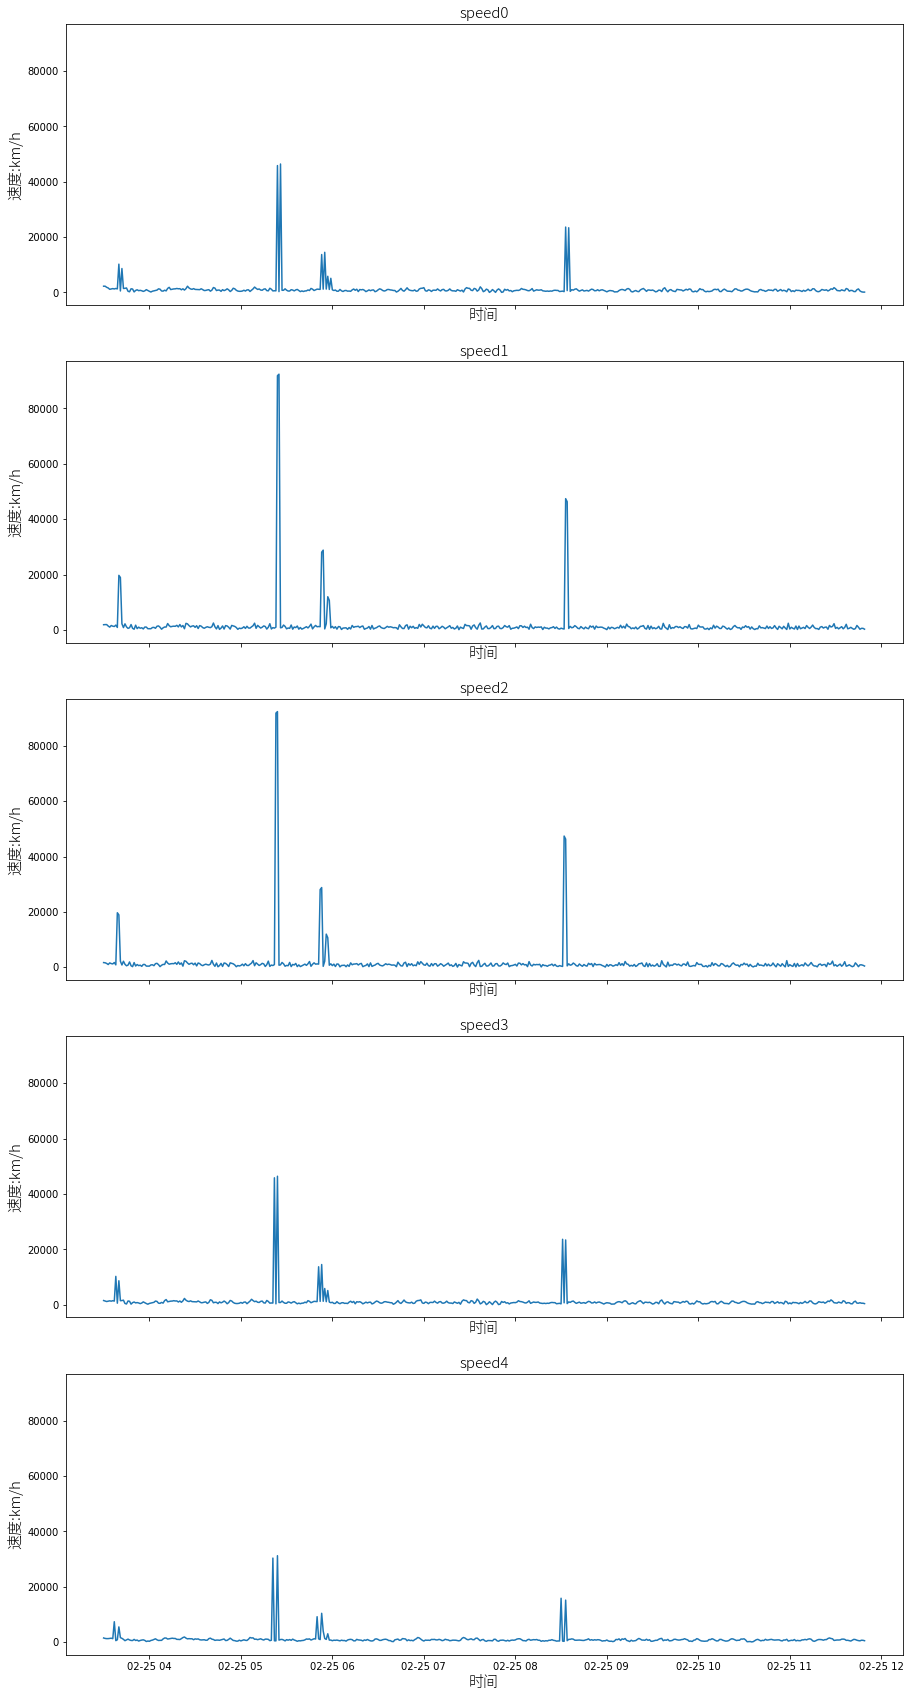

In [325]:
afterCleanGlitchBySpeed = cleanGlitchBySpeed(t,5,3000,True)

In [312]:
def drawEffectAfterCleared(origin,cleaned):
  path = '/usr/share/fonts/truetype/NotoSansSC-Light.otf'
  fontprop = fm.FontProperties(fname=path, size= 20)
  plt.figure(figsize=(30,15))
  #afterCleanGlitchBySpeed = cleanGlitchBySpeed(t,5,3000)
  plt.subplot(1, 2, 1)
  plt.title('毛刺清理前',fontproperties=fontprop)
  plt.ylabel('经度',fontproperties=fontprop)
  plt.xlabel('纬度',fontproperties=fontprop)
  plt.plot(origin.loc[:,"Lat"], origin.loc[:,'Long'], '.-')
  plt.subplot(1, 2, 2)
  plt.title('毛刺清理后',fontproperties=fontprop)
  plt.plot(cleaned.loc[:,"Lat"], cleaned.loc[:,'Long'], '.-')
  plt.xlabel('纬度',fontproperties=fontprop)
  plt.ylabel('经度',fontproperties=fontprop)
  plt.show()


## 举手表决去毛刺
飞机的最大合理速度为3000km/h，所有大于该速度的点都是潜在的毛刺点，然后采用举手表决的方式丢弃大部分认为速度不合理的点。处理的效果比较直观。

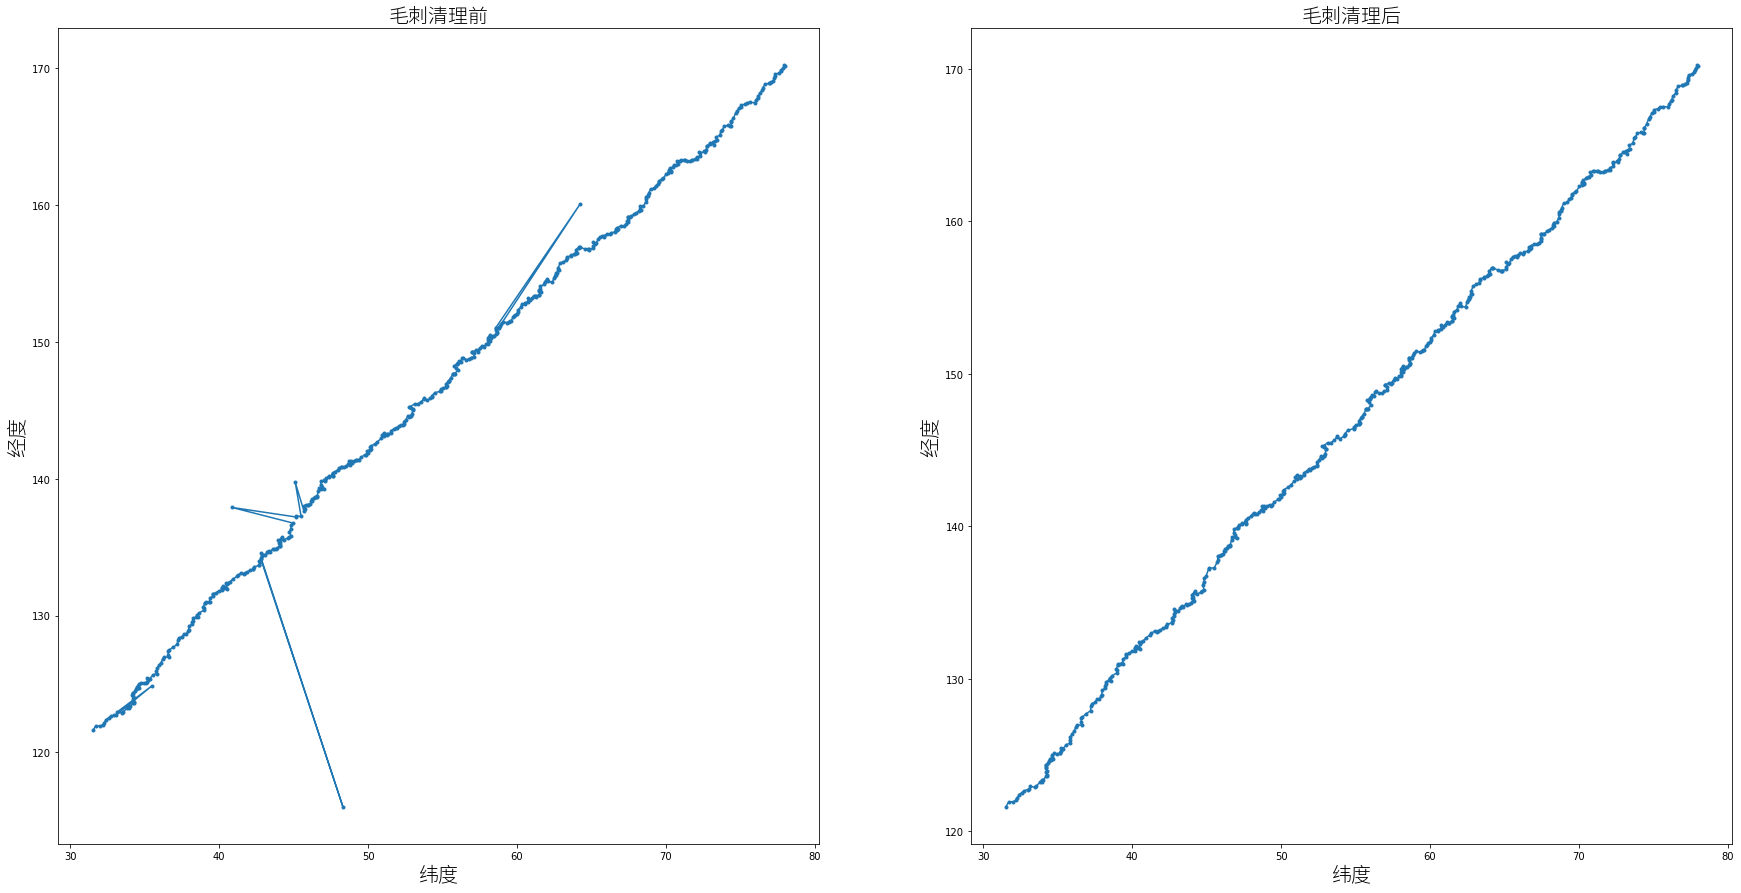

In [313]:
afterCleanGlitchBySpeed = cleanGlitchBySpeed(t,5,3000)
drawEffectAfterCleared(t,afterCleanGlitchBySpeed)